In [10]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net, MLP

In [11]:
n_epoch = 400000 #エポック
batchsize = 3000 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [12]:
xp = cuda.cupy if use_gpu is True else np

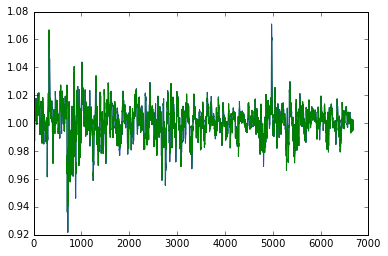

In [13]:
raw_data = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    raw_data.append(row[7])
raw_data = np.asarray(raw_data, dtype=np.float32)
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x)
plt.plot(train_data_y)

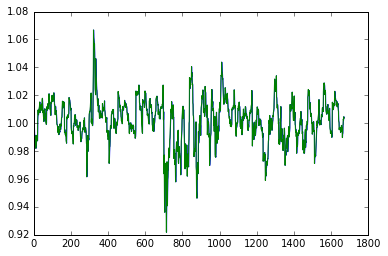

In [14]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [15]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(chainer.Variable(xp.asarray([[x_] for x_ in x])))
    error = F.mean_squared_error(out, chainer.Variable(xp.asarray([[y] for y in y], dtype=np.float32)))
    return chainer.cuda.to_cpu(out.data), error.data

In [16]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 2000 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data * len(x) / length))
        #loss.append(loss_data * batchsize / length)
        
        loss.append(evaluate(model, train_data_x, train_data_y)[1])
        test_loss.append(evaluate(model, test_data_x, test_data_y)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 2000, error 6.309047698974609
epoch 4000, error 0.019276069477200508
epoch 6000, error 0.01295201200991869
epoch 8000, error 0.010579011403024197
epoch 10000, error 0.01090326253324747
epoch 12000, error 0.010572347790002823
epoch 14000, error 0.008447510190308094
epoch 16000, error 0.00997832976281643
epoch 18000, error 0.010314722545444965
epoch 20000, error 0.010654309764504433
epoch 22000, error 0.010283034294843674
epoch 24000, error 0.008232337422668934
epoch 26000, error 0.009699080139398575
epoch 28000, error 0.009938033297657967
epoch 30000, error 0.010312537662684917
epoch 32000, error 0.009831258095800877
epoch 34000, error 0.007892771624028683
epoch 36000, error 0.009354117326438427
epoch 38000, error 0.009578478522598743
epoch 40000, error 0.009905105456709862
epoch 42000, error 0.00928599014878273
epoch 44000, error 0.0074356007389724255
epoch 46000, error 0.008992679417133331
epoch 48000, error 0.009093048982322216
epoch 50000, error 0.00938876997679472
epoch 52000

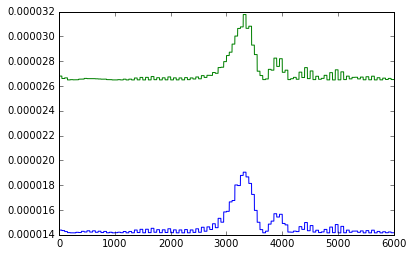

In [17]:
plt.plot(loss[-6000:])
plt.plot(test_loss[-6000:])

In [18]:
output, error = evaluate(model, train_data_x, train_data_y)

print(error)

1.41812533911434e-05


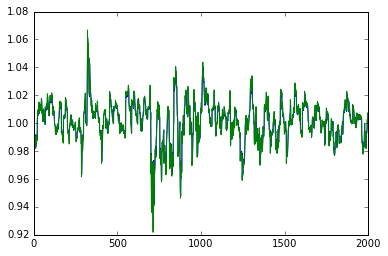

In [19]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

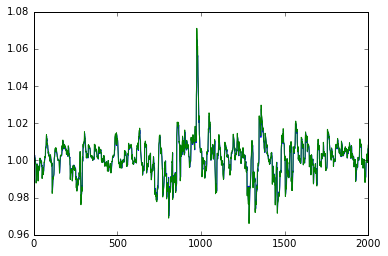

In [20]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [21]:
output, error = evaluate(model, test_data_x, test_data_y)
print('test error = {}'.format(error))

test error = 2.6547098968876526e-05


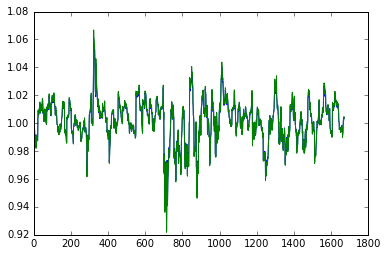

In [24]:
plt.plot(output)
plt.plot(test_data_y)